## Capstone Project 2: 재고 관리를 위한 단기(6개월) 수요 예측 모델 생성

### Part 3. XGBoost 모델

### 사용 데이터셋

> Forecasts for Product Demand: Make Accurate Forecasts for Thousands of Different Products
> - FelixZhao. kaggle. https://www.kaggle.com/felixzhao/productdemandforecasting
> - License: GPL 2

### 1. 데이터 준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib 화질 설정
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [2]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [3]:
# 데이터 불러오기
df = pd.read_csv('Historical_Data_After.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head(3)

,product_code,product_category,date,order_demand,year,month,quarter,YM,YQ
0,993,28,2012-01-19,100,2012,1,1,2012-01,2012-1
1,993,28,2012-02-08,100,2012,2,1,2012-02,2012-1
2,993,28,2012-02-22,100,2012,2,1,2012-02,2012-1


In [4]:
day_list = []

def make_month_day(month, last_day):
    global day_list

    # 월 표기를 01로 변경
    if len(str(month)) == 1:
        month = '0'+str(month)

    # 일 표기 추가
    for day in range(1, last_day):
        if len(str(day)) == 1:
            day = '0'+str(day)

        temp_date = year + '-' + str(month) + '-' + str(day)
        day_list.append(temp_date)
        
for year in ['2012', '2013', '2014', '2015', '2016']:
    for month in range(1, 13):
        
        # 31일까지 있는 달
        if month in [1, 3, 5, 7, 8, 10, 12]:
            make_month_day(month, 32)
        
        # 30일까지 있는 달
        elif month in [4, 6, 9, 11]:
            make_month_day(month, 31)
                
        else:
            month = '02'
            
            # 29일까지 있는 달
            if (year == '2012') or (year == '2016'):
                make_month_day(month, 30)
                
            # 28일까지 있는 달
            else:
                make_month_day(month, 29)

day_list = set(day_list)

print(len(day_list))

1827


In [5]:
temp_cat = pd.pivot_table(df, values='order_demand', index=['date'], columns=['product_category'], aggfunc=np.sum).fillna(0)
temp_cat.columns = list(temp_cat.columns)
temp_cat.head(3)

,1,3,5,6,7,8,9,10,11,13,15,17,18,19,20,21,22,23,24,26,28,29,30,31,32,33
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02,107.0,0.0,3500.0,13000.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,653950.0,0.0,100.0,0.0,0.0,55.0,0.0,0.0,0.0,9000.0,0.0,540.0,0.0
2012-01-03,25.0,0.0,33600.0,72400.0,6952.0,0.0,1576.0,0.0,151.0,0.0,208.0,0.0,19.0,1499806.0,1000.0,917.0,62.0,170.0,1058.0,114.0,8053.0,0.0,18600.0,10.0,36.0,0.0


In [6]:
# 빈 날짜 목록 생성
temp_cat_index = set(temp_cat.index)
need = day_list - temp_cat_index
print(len(need))

# 빈 날짜의 수요량은 0로 채우기
for idx in list(need):
    temp_cat.loc[idx] = 0

temp_cat = temp_cat.sort_index()

print(temp_cat.shape)

147
(1827, 26)


In [7]:
temp_product = pd.pivot_table(df, values='order_demand', index=['date'], columns=['product_code'], aggfunc=np.sum).fillna(0)
temp_product.columns = list(temp_product.columns)
temp_product.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,2132,2133,2134,2135,2136,2137,2138,2139,2140,2141,2142,2143,2144,2145,2146,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0
2012-01-03,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,153.0,0.0,0.0,20.0,0.0,0.0,1164.0,200.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
# 빈 날짜 목록 생성
temp_product_index = set(temp_product.index)
need = day_list - temp_product_index
print(len(need))

# 빈 날짜의 수요량은 0로 채우기
for idx in list(need):
    temp_product.loc[idx] = 0

temp_product = temp_product.sort_index()

print(temp_product.shape)

147
(1827, 2125)


In [9]:
# 카테고리 19만 선택
cat_19 = temp_cat[[19]]
cat_19 = cat_19.reset_index()
cat_19.columns = ['date', 'order_demand']

print(cat_19.shape)
cat_19.head()

(1827, 2)


,date,order_demand
0,2012-01-01,0.0
1,2012-01-02,653950.0
2,2012-01-03,1499806.0
3,2012-01-04,626100.0
4,2012-01-05,7458199.0


### 2. 모델 생성

In [10]:
# date에서 year, month, day, quarter, day of week, week of year 추출
time_19 = cat_19.reset_index(drop=True)

time_19['date'] = pd.to_datetime(time_19['date'])

time_19['year'] = time_19['date'].dt.year
time_19['month'] = time_19['date'].dt.month
time_19['day'] = time_19['date'].dt.day
time_19['quarter'] = time_19['date'].dt.quarter
time_19['day_of_week'] = time_19['date'].dt.dayofweek
time_19['week_of_year'] = time_19['date'].dt.isocalendar().week
time_19['week_of_year'] = time_19['week_of_year'].astype(int)

In [11]:
# train, validation data set 생성
train = time_19[time_19['date'] < '2016-07-01']
val = time_19[time_19['date'] >= '2016-07-01']
print(train.shape, val.shape)

(1643, 8) (184, 8)


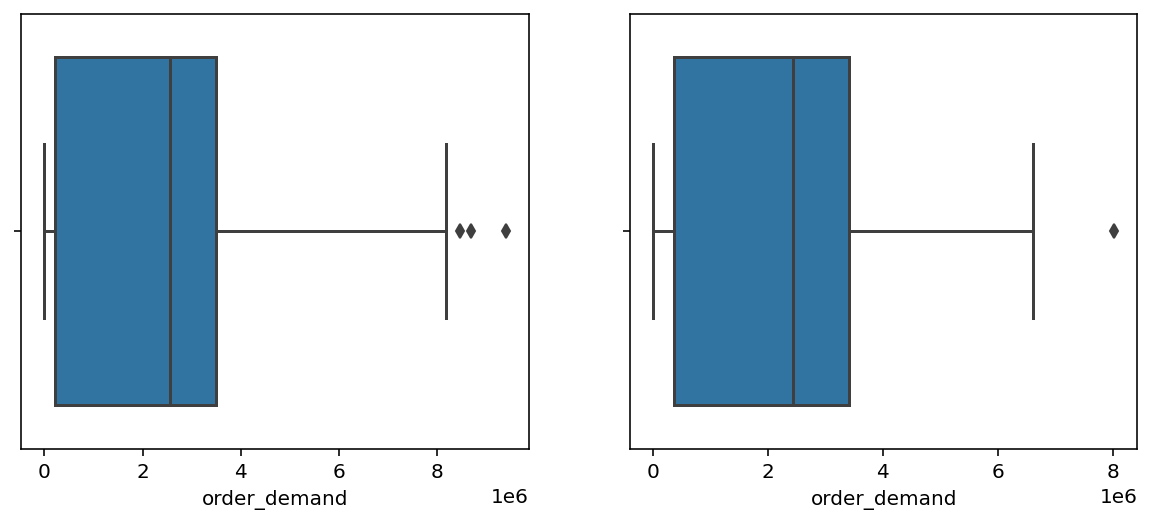

In [12]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
sns.boxplot(data=train, x='order_demand')

plt.subplot(122)
sns.boxplot(data=val, x='order_demand');

train data set과 validation data set의 분포와 범위가 비슷한 것을 확인할 수 있다.

In [13]:
# Feature와 Target 분리
target = 'order_demand'
features = train.drop([target, 'date'], axis=1).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1643, 6) (1643,)
(184, 6) (184,)


In [14]:
# 확인
X_train.head(3)

,year,month,day,quarter,day_of_week,week_of_year
0,2012,1,1,1,6,52
1,2012,1,2,1,0,1
2,2012,1,3,1,1,1


In [15]:
X_val.head(3)

,year,month,day,quarter,day_of_week,week_of_year
1643,2016,7,1,3,4,26
1644,2016,7,2,3,5,26
1645,2016,7,3,3,6,26


#### a. 시간 정보를 feature로 사용

EDA를 했을때는 시간, 계절에 따른 주기가 없어보이긴 했지만, 각 연도, 월, 일, 분기, 요일, 그리고 몇 주차인지를 feature로 사용해서 모델을 만들어보았다.

##### 1) 전체 기간 데이터 사용

In [16]:
# 파이프라인 생성 및 학습
xgb_basic = make_pipeline(
    SimpleImputer(),
    RobustScaler(),
    XGBRegressor(random_state=1,
                 n_jobs=-1,
                 objective='reg:squarederror',
                 max_depth=8,
                 learning_rate=0.2))

xgb_basic.fit(X_train, y_train);

In [17]:
# 예측
y_pred = xgb_basic.predict(X_val)

# 결과 확인

print('mae:  ', mae(y_val, y_pred))
print('rmae: ', np.sqrt(mse(y_val, y_pred)))

mae:   756957.9844944166
rmae:  1096979.8721519536


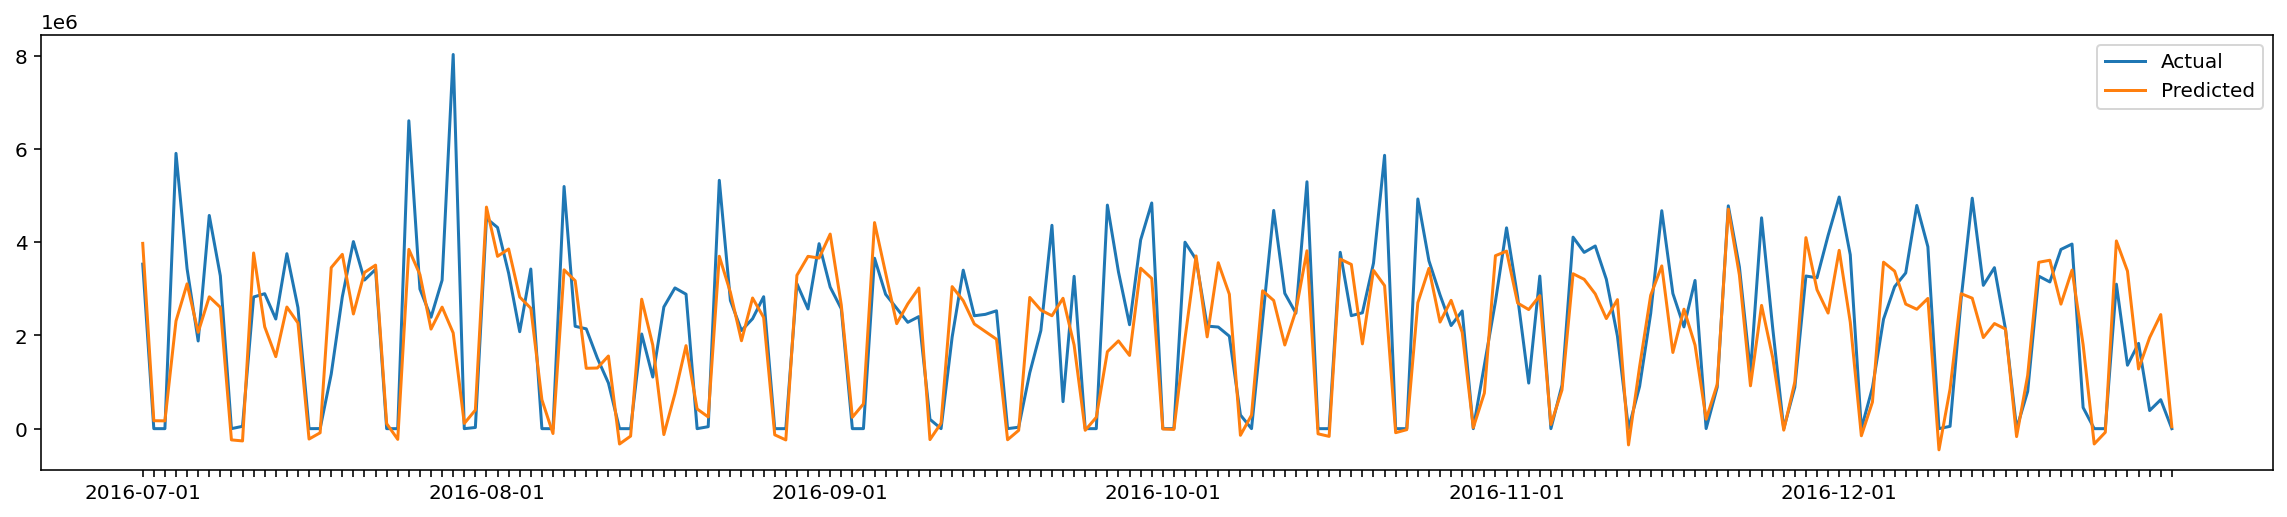

In [18]:
plt.figure(figsize=(20, 4))
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], cat_19[cat_19['date'] >= '2016-07-01']['order_demand'], label='Actual')
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], y_pred, label='Predicted')

labels = [item if item[-2:] == '01' else '' for item in sorted(day_list) if ((item[:4] == '2016') and (item[5:7] >= '07'))]
plt.xticks(cat_19[cat_19['date'] >= '2016-07-01']['date'], labels)
plt.legend()
plt.show();

위 그림은 2012년에서 2015년 데이터를 모두 학습에 사용한 모델의 예측 결과를 시각화 한 것이다.

##### 2) 2015년 데이터만 사용

In [19]:
# 파이프라인 생성 및 학습
xgb_basic = make_pipeline(
    SimpleImputer(),
    RobustScaler(),
    XGBRegressor(random_state=1,
                 n_jobs=-1,
                 objective='reg:squarederror',
                 max_depth=8,
                 learning_rate=0.2))

xgb_basic.fit(X_train[X_train['year']==2015], y_train[X_train[X_train['year']==2015].index]);

In [20]:
# 예측
y_pred = xgb_basic.predict(X_val)

# 결과 확인
print('mae:  ', mae(y_val, y_pred))
print('rmae: ', np.sqrt(mse(y_val, y_pred)))

mae:   810151.9397244661
rmae:  1186488.8705215105


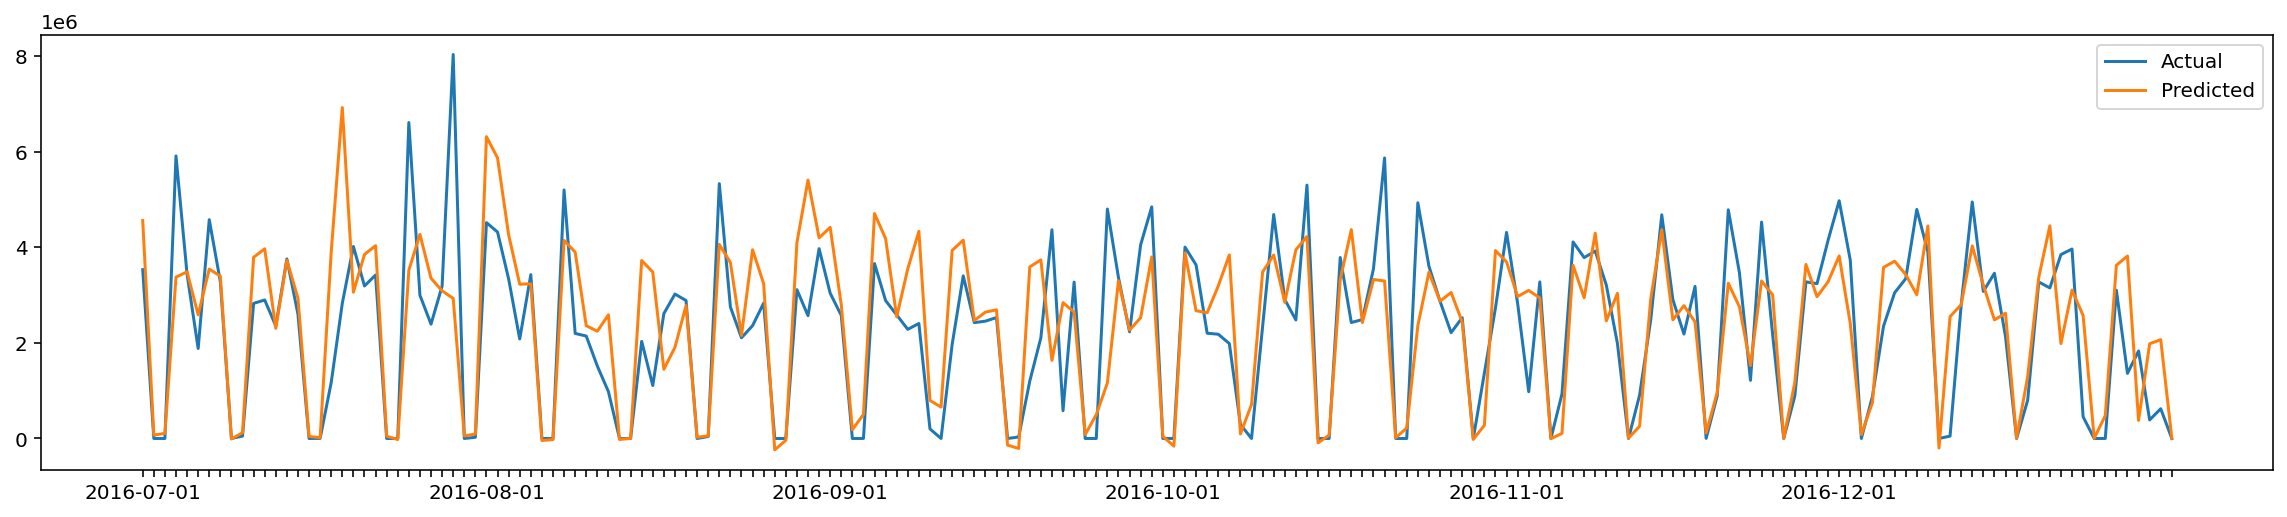

In [21]:
plt.figure(figsize=(20, 4))
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], cat_19[cat_19['date'] >= '2016-07-01']['order_demand'], label='Actual')
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], y_pred, label='Predicted')

labels = [item if item[-2:] == '01' else '' for item in sorted(day_list) if ((item[:4] == '2016') and (item[5:7] >= '07'))]
plt.xticks(cat_19[cat_19['date'] >= '2016-07-01']['date'], labels)
plt.legend()
plt.show();

위 그림은 2015년 데이터만 학습에 사용한 모델의 예측 결과를 시각화한 것이다.

#### b. Lag 방식 사용

In [ ]:
# lag 생성
for num in range(1, 41):
  cat_19['t-'+str(num)] = cat_19['order_demand'].shift(num)

In [ ]:
# 다 nan인 row 제거
cat_19 = cat_19.drop(0).reset_index(drop=True)

In [ ]:
# train, validation data set 생성
train_lag = cat_19[cat_19['date'] < '2016-07-01']
val_lag = cat_19[cat_19['date'] >= '2016-07-01']

In [ ]:
# 2015년만 선택
train_lag_2015 = train_lag[train_lag['date'] >= '2015-01-01']

In [ ]:
# feature, target 분리
X_train_lag = train_lag.drop(['date', 'order_demand'], axis=1)
y_train = train_lag['order_demand']

X_train_lag_2015 = train_lag_2015.drop(['date', 'order_demand'], axis=1)
y_train_2015 = train_lag_2015['order_demand']

X_val_lag = val_lag.drop(['date', 'order_demand'], axis=1)
y_val = val_lag['order_demand']

In [ ]:
# 확인
print(X_train_lag.shape, y_train.shape)
print(X_train_lag_2015.shape, y_train_2015.shape)
print(X_val_lag.shape, y_val.shape)
X_train_lag.head(3)

(1642, 40) (1642,)
(547, 40) (547,)
(184, 40) (184,)


,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30,t-31,t-32,t-33,t-34,t-35,t-36,t-37,t-38,t-39,t-40
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,653950.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1499806.0,653950.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 결과를 저장할 dataframe 생성
result_df = pd.DataFrame({
    'lag': [0, 0],
    'only_2015': [0, 1],
    'mae': [756957.98, 1096979.87],  # 시간 정보를 feature로 사용한 모델의 결과
    'rmse': [810151.94, 1186488.87]
})
result_df

,lag,only_2015,mae,rmse
0,0,0,756957.98,810151.94
1,0,1,1096979.87,1186488.87


##### 1) 전체 기간 데이터 사용

In [ ]:
for num in range(1, 41):
  
  # 파이프라인 생성 및 학습
    xgb_basic = make_pipeline(
      SimpleImputer(),
      RobustScaler(),
      XGBRegressor(random_state=1,
                  n_jobs=-1,
                  objective='reg:squarederror',
                  max_depth=5,
                  learning_rate=0.2))

    xgb_basic.fit(X_train_lag.iloc[num-1:, :num], y_train[X_train_lag.iloc[num-1:, :num].index])

    # 예측
    y_pred = xgb_basic.predict(X_val_lag.iloc[:, :num])

    # 결과 정리
    new_row = {'lag':num,
             'only_2015':0,
             'mae':round(mae(y_val, y_pred), 2),
             'rmse':round(np.sqrt(mse(y_val, y_pred)), 2)}
  
    result_df = result_df.append(new_row, ignore_index=True)

In [ ]:
result_df.head(3)

,lag,only_2015,mae,rmse
0,0.0,0.0,756957.98,810151.94
1,0.0,1.0,1096979.87,1186488.87
2,1.0,0.0,1304016.02,1724533.40


##### 2) 2015년 데이터만 사용

In [ ]:
for num in range(1, 41):

  # 파이프라인 생성 및 학습
  xgb_basic = make_pipeline(
      SimpleImputer(),
      RobustScaler(),
      XGBRegressor(random_state=1,
                  n_jobs=-1,
                  objective='reg:squarederror',
                  max_depth=5,
                  learning_rate=0.2))

  xgb_basic.fit(X_train_lag_2015.iloc[num-1:, :num], y_train[X_train_lag_2015.iloc[num-1:, :num].index])

  # 예측
  y_pred = xgb_basic.predict(X_val_lag.iloc[:, :num])

  # 결과 정리
  new_row = {'lag':num,
             'only_2015':1,
             'mae':round(mae(y_val, y_pred), 2),
             'rmse':round(np.sqrt(mse(y_val, y_pred)), 2)}
  result_df = result_df.append(new_row, ignore_index=True)

In [ ]:
result_df.tail()

,lag,only_2015,mae,rmse
77,36.0,1.0,771918.22,1094053.59
78,37.0,1.0,755039.32,1084547.01
79,38.0,1.0,809297.82,1138192.04
80,39.0,1.0,749233.47,1084149.05
81,40.0,1.0,784437.78,1108905.15


#### c. 결과 확인

In [ ]:
# 상위 20개 (mae가 작은 순)
result_df.sort_values(by='mae').head(20)

,lag,only_2015,mae,rmse
38,37.0,0.0,700843.85,1028137.96
41,40.0,0.0,704351.82,1030994.48
51,10.0,1.0,727082.71,1065156.70
32,31.0,0.0,729783.07,1068564.24
37,36.0,0.0,733685.45,1064905.98
39,38.0,0.0,735806.17,1057835.82
22,21.0,0.0,736626.07,1089807.19
14,13.0,0.0,739091.71,1073284.95
23,22.0,0.0,739718.34,1097873.97
35,34.0,0.0,740866.45,1066431.03


In [ ]:
# 하위 20개
result_df.sort_values(by='mae').tail(20)

,lag,only_2015,mae,rmse
58,17.0,1.0,800314.51,1133738.06
49,8.0,1.0,802497.91,1153054.72
74,33.0,1.0,805198.51,1160007.70
18,17.0,0.0,808115.71,1156647.25
79,38.0,1.0,809297.82,1138192.04
24,23.0,0.0,813622.03,1151229.74
60,19.0,1.0,821040.86,1179619.16
6,5.0,0.0,860126.44,1224676.13
7,6.0,0.0,876646.04,1221012.24
47,6.0,1.0,893037.85,1206095.85


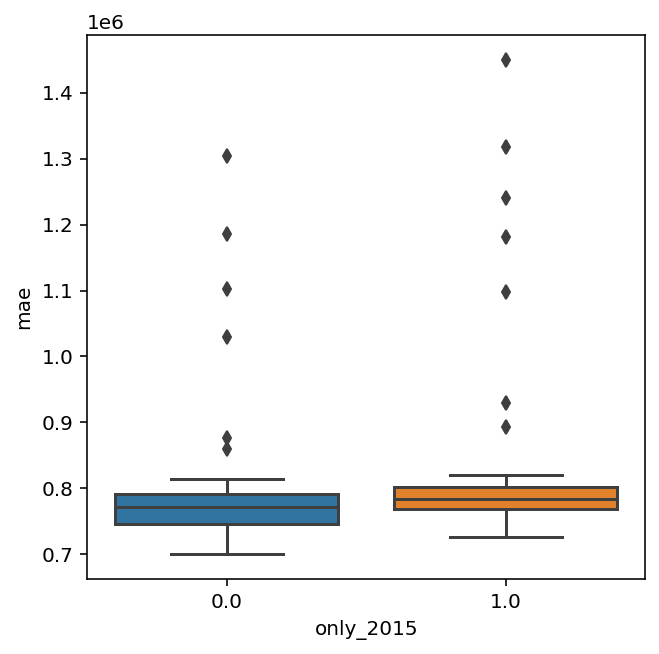

In [ ]:
# 전체 데이터 사용과 2015년 데이터만 사용 결과 비교
plt.figure(figsize=(5, 5))
sns.boxplot(data=result_df, x='only_2015', y='mae')
plt.show();

대체로 2015년 데이터만 사용하여 학습한 모델보다 전체 기간을 모두 사용하여 학습한 모델의 성능이 더 좋다. 가장 mae가 작은 모델은 37일 lag와 전체 데이터를 사용한 모델로, mae가 약 700, 844이다.

In [ ]:
xgb_basic = make_pipeline(
    SimpleImputer(),
    RobustScaler(),
    XGBRegressor(random_state=1,
                n_jobs=-1,
                objective='reg:squarederror',
                max_depth=5,
                learning_rate=0.2))

xgb_basic.fit(X_train_lag.iloc[36:, :37], y_train[X_train_lag.iloc[36:, :37].index])

# 예측
y_pred = xgb_basic.predict(X_val_lag.iloc[:, :37])

# 결과 정리
print('mae :', round(mae(y_val, y_pred), 2))
print('rmse :', round(np.sqrt(mse(y_val, y_pred)), 2))

mae : 700843.85
rmse : 1028137.96


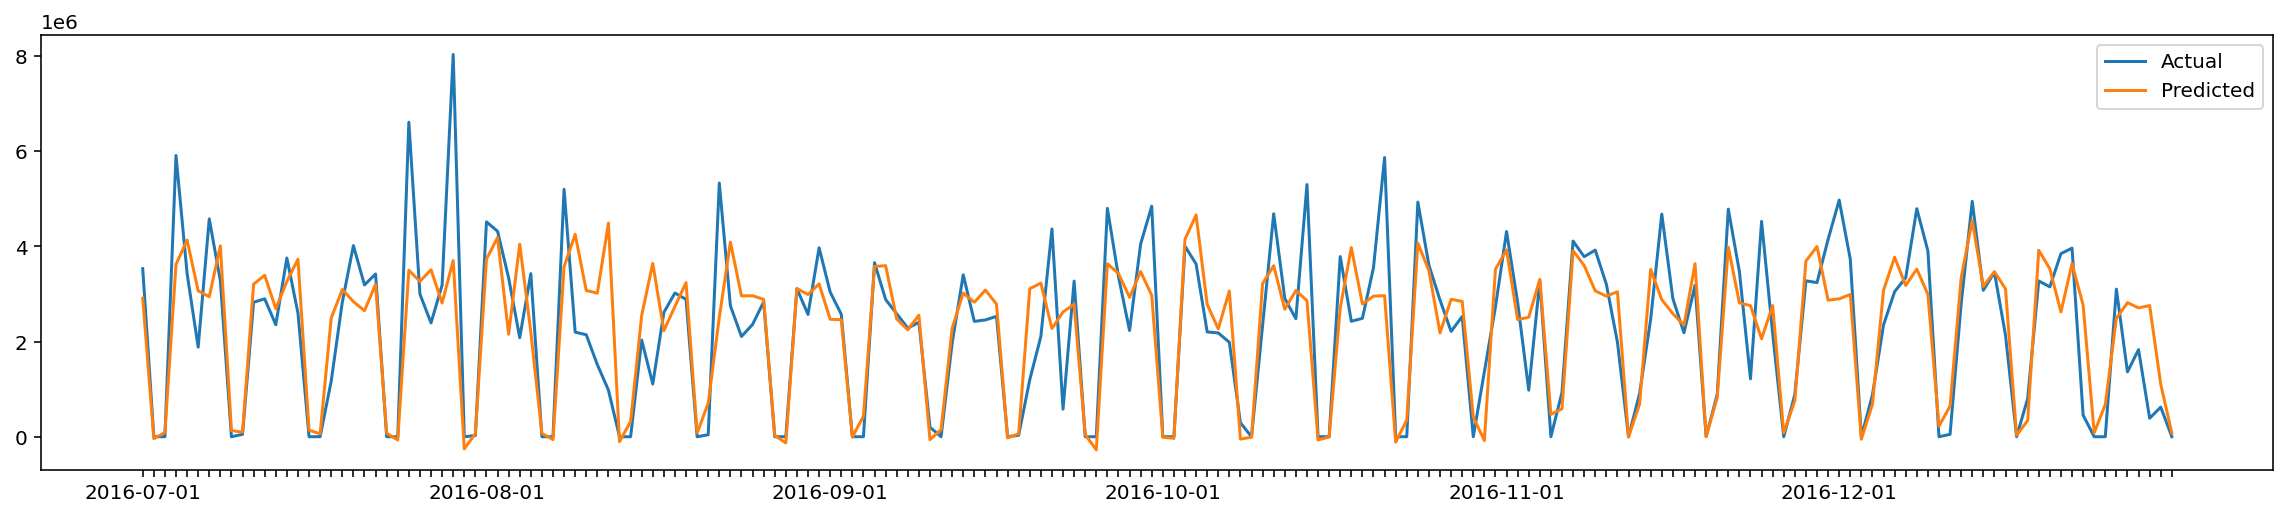

In [ ]:
# 시각화
plt.figure(figsize=(20, 4))
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], cat_19[cat_19['date'] >= '2016-07-01']['order_demand'], label='Actual')
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], y_pred, label='Predicted')

labels = [item if item[-2:] == '01' else '' for item in sorted(day_list) if ((item[:4] == '2016') and (item[5:7] >= '07'))]
plt.xticks(cat_19[cat_19['date'] >= '2016-07-01']['date'], labels)
plt.legend()

plt.show();

### 3. 하이퍼 파라미터 튜닝

위에서 가장 mae가 작았던 37일 lag와 전체 데이터를 사용한 모델을 하이퍼 파라미터 튜닝을 하여 성능을 개선시켜보았다.

In [ ]:
# eval set 생성
pre_processing_part = make_pipeline(
    SimpleImputer(),
    RobustScaler())

X_train_lag_processing = pre_processing_part.fit_transform(X_train_lag.iloc[36:, :37])
X_val_lag_processing = pre_processing_part.transform(X_val_lag.iloc[:, :37])

eval_set = [(X_train_lag_processing, y_train[X_train_lag.iloc[36:, :37].index]),
            (X_val_lag_processing, y_val)]

In [ ]:
# 모델 생성
xgb_hyper = XGBRegressor(
    random_state=1,
    n_jobs=-1,
    objective='reg:squarederror')

# 사용할 하이퍼 파라미터
dists = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0.01, 0, 0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]}

# cv
cv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
reg_xgb_hyper = GridSearchCV(
    xgb_hyper, 
    param_grid=dists,
    cv=cv, 
    scoring='neg_mean_absolute_error',
    verbose=10,
    n_jobs=-1
)

reg_xgb_hyper.fit(X_train_lag_processing,
                  y_train[X_train_lag.iloc[36:, :37].index],
                  eval_set = eval_set,
                  eval_metric='mae',
                  early_stopping_rounds = 50);

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1

[0]	validation_0-mae:2.10158e+06	validation_1-mae:2.03204e+06
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:1.89959e+06	validation_1-mae:1.83136e+06
[2]	validation_0-mae:1.72039e+06	validation_1-mae:1.6553e+06
[3]	validation_0-mae:1.56292e+06	validation_1-mae:1.49857e+06
[4]	validation_0-mae:1.42523e+06	validation_1-mae:1.36758e+06
[5]	validation_0-mae:1.30446e+06	validation_1-mae:1.25426e+06
[6]	validation_0-mae:1.19779e+06	validation_1-mae:1.15066e+06
[7]	validation_0-mae:1.10523e+06	validation_1-mae:1.0593e+06
[8]	validation_0-mae:1.02457e+06	validation_1-mae:982071
[9]	validation_0-mae:955499	validation_1-mae:915998
[10]	validation_0-mae:896717	validation_1-mae:865328
[11]	validation_0-mae:845454	validation_1-mae:822918
[12]	validation_0-mae:801728	validation_1-mae:792056
[13]	validation_0-mae:765188	validation_1-mae:768156
[14]	validation_0-mae:736098

[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 18.3min finished


[18]	validation_0-mae:663871	validation_1-mae:710853
[19]	validation_0-mae:652569	validation_1-mae:706389
[20]	validation_0-mae:643631	validation_1-mae:703127
[21]	validation_0-mae:636466	validation_1-mae:697676
[22]	validation_0-mae:630282	validation_1-mae:696868
[23]	validation_0-mae:625243	validation_1-mae:696987
[24]	validation_0-mae:621619	validation_1-mae:698910
[25]	validation_0-mae:618552	validation_1-mae:699677
[26]	validation_0-mae:616144	validation_1-mae:700305
[27]	validation_0-mae:612833	validation_1-mae:701175
[28]	validation_0-mae:610333	validation_1-mae:701836
[29]	validation_0-mae:607893	validation_1-mae:702442
[30]	validation_0-mae:605173	validation_1-mae:701255
[31]	validation_0-mae:601814	validation_1-mae:701052
[32]	validation_0-mae:599923	validation_1-mae:703208
[33]	validation_0-mae:598547	validation_1-mae:702575
[34]	validation_0-mae:596877	validation_1-mae:701757
[35]	validation_0-mae:596021	validation_1-mae:702007
[36]	validation_0-mae:594650	validation_1-mae:

In [ ]:
# 결과 확인
print('best hyper-parameter: ', reg_xgb_hyper.best_params_)

best hyper-parameter:  {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3}


In [ ]:
# cv 결과 확인
pd.DataFrame(reg_xgb_hyper.cv_results_).sort_values(by='rank_test_score').head().T

,170,50,410,290,530
mean_fit_time,0.483332,0.479378,0.489456,0.481913,0.482014
std_fit_time,0.114524,0.135819,0.135385,0.135433,0.111454
mean_score_time,0.00134978,0.00175619,0.00145845,0.00163145,0.00150576
std_score_time,0.000145076,0.000223754,0.000218317,0.000297323,0.000226704
param_gamma,0,0.01,0.2,0.1,0.3
param_learning_rate,0.1,0.1,0.1,0.1,0.1
param_max_depth,3,3,3,3,3
param_min_child_weight,3,3,3,3,3
params,"{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...","{'gamma': 0.01, 'learning_rate': 0.1, 'max_dep...","{'gamma': 0.2, 'learning_rate': 0.1, 'max_dept...","{'gamma': 0.1, 'learning_rate': 0.1, 'max_dept...","{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."
split0_test_score,-703969,-703969,-703969,-703969,-703969


In [ ]:
# 모델 저장
model_xgb_hyper = reg_xgb_hyper.best_estimator_

# 예측
y_pred = model_xgb_hyper.predict(X_val_lag_processing)

# 결과 정리
print('mae :', round(mae(y_val, y_pred), 2))
print('rmse :', round(np.sqrt(mse(y_val, y_pred)), 2))

mae : 696867.72
rmse : 1045262.82


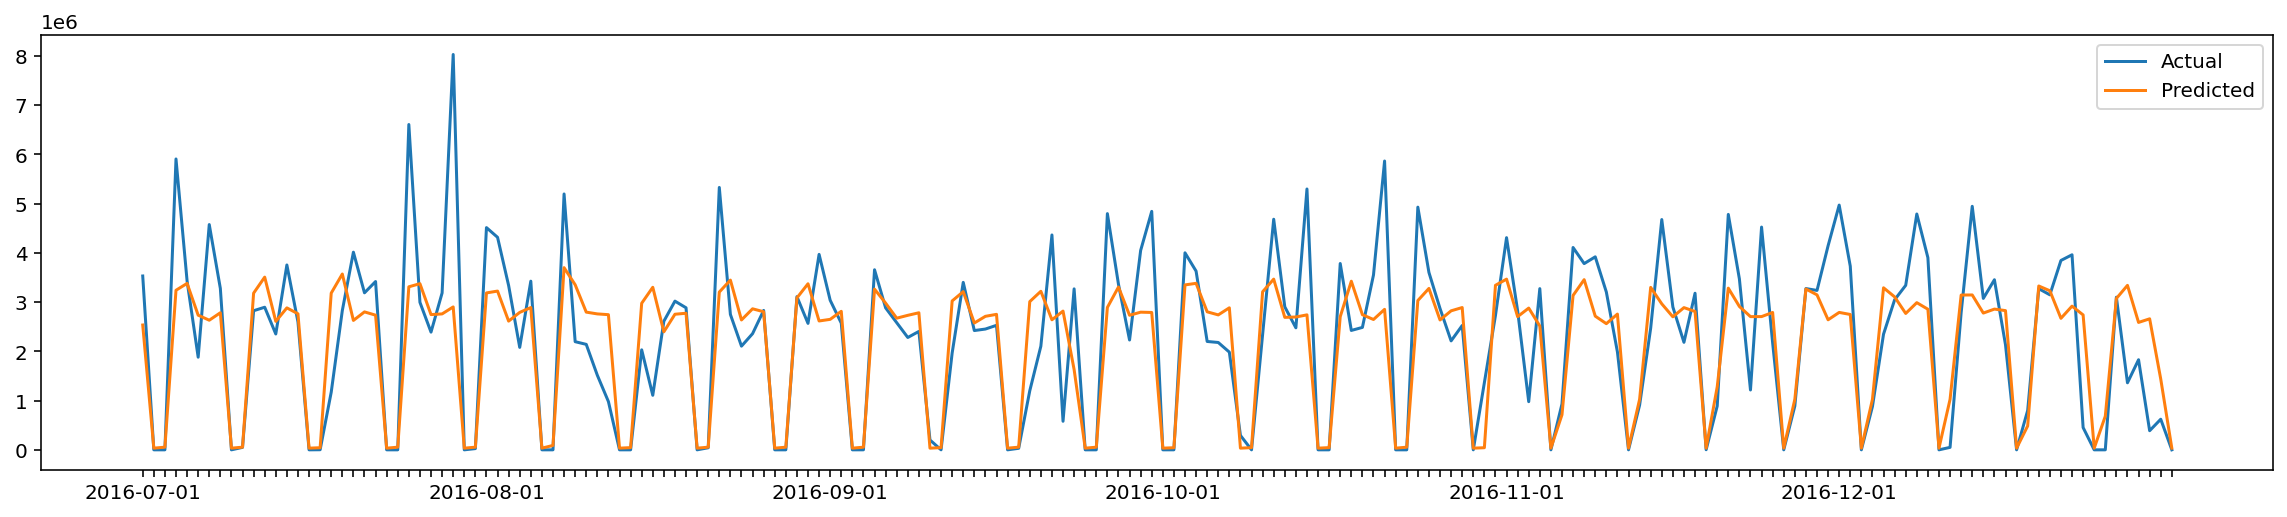

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], cat_19[cat_19['date'] >= '2016-07-01']['order_demand'], label='Actual')
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], y_pred, label='Predicted')

labels = [item if item[-2:] == '01' else '' for item in sorted(day_list) if ((item[:4] == '2016') and (item[5:7] >= '07'))]
plt.xticks(cat_19[cat_19['date'] >= '2016-07-01']['date'], labels)
plt.legend()

plt.show();

하이퍼 파라미터를 튜닝하기 전 모델의 validation dataset에 대한 mae는 약 700,844였는데, 하이퍼 파라미터 튜닝 후 약 696,868로 감소하였다. 이 값은 baseline이었던 ARIMA 모델의 mae인 약 1,566,822보다 작기 때문에 의미있는 모델이라고 할 수 있다.

### 4. 모델 저장

In [ ]:
import pickle
import gzip

def save_as_pickle(data, file_name):
    
    with gzip.open(file_name, 'wb') as f:
        pickle.dump(data, f)

# 모델 저장
save_as_pickle(model_xgb_hyper, 'model_xgb_hyper_save.pickle')